
## 11장 DSL 만들기

영역 특화 언어(Domain Specific Language) = DSL 에 대해 살펴볼 것이다.

이 중 두 가지 특성이 있다.

1. 수신 객체 지정 람다

 - 수신 객체 지정 람다를 사용하면 코드 블록에서 이름(변수)가 가리키는 대상을 정할 수 있다.
 - invoke convention 을 사용하면 DSL 코드 안에서 람다와 프로퍼티 대입을 더 유연하게 조합 할 수 있다.

### API 에서 DSL
개발자가 객체지향 프로그래밍에서 지향해야할 목표는 가독성이 높고 유지보수성이 좋은 코드를 작성하고 객체간의 관계를 잘 설계하는 것이라고 할 수 있다.

코틀린에서는 객체를 위한 API를 깔끔하게 작성하기 위한 여러 코틀린적 특성을 알아 보았다.

API 가 깔금하다는 것은 어떠한 의미?

- 코드를 읽는자 가 어떤일이 벌어질지 명확하게 이해할 수 있어야한다.
- 코드가 간결해야 한다

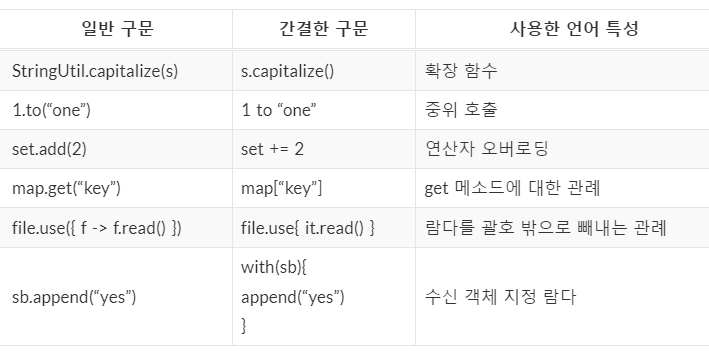

코틀린 DSL은 간결한 구문을 제공하는 기능과 그런 구문을 확장해 여러 메소드 호출을 조합함으로써 구조를 만들어내는 기능에 의존한다.

val yesterday = 1.days.ago
// DSL을 사용하면 다음과 같이 하루 전 날을 반환 받을 수 있다.

In [ ]:
fun createSimpleTable() = createHTML().
    table {
        tr {
            td {
                +"cell"
            }
        }
    }

## 영역 특화 언어

DSL이라는 개념은 오래된 개념이다.

범용 프로그래밍 언어를 기반으로 하여 필요하지 않은 기능을 없앤 영역 특화 언어를 DSL이라고 부른다.

우리에게 가장 익숙한 DSL은 SQL과 정규식이다.

__이러한 DSL은 범용 프로그래밍언어와 달리 선언형 이라는 점이 중요하다. 범용 프로그래밍 언어는 주로 명령형이다.__

- 선언형
    - 장점은 결과를 기술하기만 하고 그 결과를 달성하기 위한 세부 실행은 언어를 해석하는 엔진에 맡겨버린다.

        실행 엔진이 결과를 얻는 과정을 전체적으로 최적화하기 때문에 declarative 언어가 더 효율적인 경우가 종종 있다.

        그러나 이러한 declarative 언어에도 한 가지 단점이 존재한다.

        바로 DSL을 범용 언어로 만든 애플리케이션과 조합하기가 어렵다는 점이다.

        DSL은 자체 문법이 있기 때문에 다른 언어의 프로그램 안에 직접 포함시킬 수 없다.
        
    - 이러한 문제를 극복하기 위해 Internal DSL 이라는 개념이 유명해지고 있다.
        

- Internal DSL

    - 독립적인 문법 구조를 가진 external DSL과 반대로 internal DSL은 범용 언어로 작성된 프로그래밍의 일부이며 범용 언어와 동일한 문법을 사용한다.

        따라서 internal DSL은 다른 언어가 아니라 DSL의 핵심 장점을 유지하면서 주 언어를 특별한 방법으로 사용하는 것이다.

In [ ]:
SELECT Country.name, COUNT(Customer.id)
    FROM Country
    JOIN Customer
        ON Country.id = Customer.country_id
GROUP BY Country.name
ORDER BY COUNT(Customer.id) DESC
    LIMIT 1

코틀린으로 작성된 데이터베이스 프레임워크인 Exposed 프레임워크가 제공하는 DSL을 사용하여 같은 질의를 구현하면 아래와 같다.

~~~
(Country join Customer)
    .slice(Country.name, Count(Customer.id))
    .selectAll()
    .groupBy(Country.name)
    .orderBy(Count(Customer.id),isAsc = false)
    .limit(1)
~~~    
    
위 프로그램을 실행하면 첫 번째 SQL과 동일한 프로그램이 생성되고 실행된다.

하지만 두 번째 코드는 일반 코틀린 코드이며 일반 코틀린 메소드를 사용한다.

또한 두 번째 코드는 SQL 질의가 반환하는 결과 집합을 코틀린 객체로 변환하기 위해 특별히 해줄 것이 없다.

쿼리를 실행한 결과가 네이티브 코틀린 객체이기 때문이다.

두 번째 코드를 internal DSL 이라고 부른다.

## DSL 구조

- 코틀린 DSL에서는 보통 람다를 중첩시키거나 메소드 호출을 연쇄시키는 방식으로 구조를 만든다.

    그런 구조는 위에서 살펴본 SQL 예제에서 역시 확인할 수 있다.

    질의를 실행하기 위해 필요한 메소드들을 조합해야하며, 그렇게 메소드를 조합해서 만든 질의는 질의에 필요한 인자를 메소드 호출 하나에 모두 넘기는 것 보다 훨씬 더 가독성이 높다.

In [ ]:
//kotlin test
sangwon should startWith("san")

// Junit
assertTrue(sangwon.startWith("san"))

## 수신 객체 지정 람다와 확장 함수 타입

- with나 apply같은 scope function에서 수신 객체 지정 람다에 대해 소개했었다.

    이제 buildString 함수를 통해 코틀린이 수신 객체 지정 람다를 어떻게 구현하는지 살펴보자.

- buildString은 한 StringBuilder 객체에 여러 내용을 추가할 수 있다.

    람다를 인자로 받는 buildString()을 정의해보자.

In [ ]:
fun buildString(
    builderAction: (StringBuilder) -> Unit
) : String {
    val sb = StringBuilder()
    builderAction(sb)
    return sb.toString()
}

val s = buildString {
    it.append("Hello, ")
    it.append("World!")
}

println(s)
// Hello, World!

이 코드는 이해하기 쉽지만 사용하기 편리하지는 않다.

람다 본문에서 매번 it을 사용해 StringBuilder를 참조해야하기 때문이다.

이번에는 수신 객체 지정 람다를 사용하여 it이라는 이름을 사용하지 않는 람다를 인자로 넘겨보자.

In [ ]:
fun buildString(
    builderAction: StringBuilder.() -> Unit
) : String {
    val sb = StringBuilder()
    sb.builderAction()
    return sb.toString()
}

val s = buildString {
    this.append("Hello, ")
    append("World!")
}

println(s)
// Hello, World!

이제 람다를 수신 인자로 보낼 수 있기 때문에, it을 제거해도 된다. 따라서 this.append()의 형태로 사용 가능하다.

우선 builderAction의 타입이 달라졌다.

이는 확장 함수 타입을 사용했다.

확장 함수 타입 선언은 람다의 파라미터 목록에 있는 수신 객체 타입을 파라미터 목록을 여는 괄호 앞으로 빼 놓으면서 중간에 마침표를 붙인 형태다.

- 확장 함수 타입 선언 과정

(StringBuilder) -> StringBuilder() -> StringBuilder.()

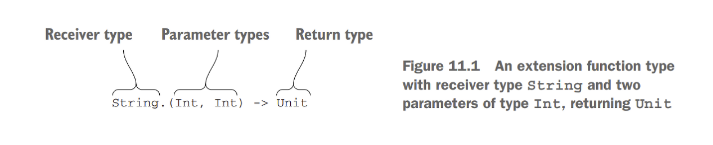

### 확장 함수의 본문에서는 확장 대상 클래스에 정의된 메소드를 마치 그 클래스 내부에서 호출하듯이 사용할 수 있었다.

### 확장 함수나 수신 객체 지정 람다에서는 모두 함수(람다)를 호출할 때 수신 객체를 지정해야만 하고, 함수(람다) 본문 안에서는 그 수신 객체를 특별한 수식자 없이 사용할 수 있다.

In [ ]:
표준 라이브러리의 buildString 구현은 위의 구현보다 훨씬 짧은데, builderAction을 명시적으로 호출하는 대신 builderAction을 apply 함수에게 인자로 넘긴다.

이렇게 하면 builderString을 단 한줄로 구현할 수 있다.

fun buildString(builderAction: StringBuilder.() -> Unit): String = StringBuilder().apply(builderAction).toString()


with와 apply 모두 수신 객체로 확장 함수 타입의 람다를 호출한다.

In [ ]:
inline fun <T> T.apply(block: T.() -> Unit): T {
    block()
    return this
}

inline fun<T,R> with(receiver: T, block: T.() -> R) : R {
    receiver.block()
}

차이가 있다면 apply의 경우 수신 객체의 메소드처럼 불리며, 수신 객체를 묵시적 인자(this)로 받는다.

이에 비해 with는 수신 객체를 첫 번째 파라미터로 받는다.

또 다른 차이는, apply의 경우 수신 객체를 다시 반환하지만 with의 경우 람다를 호출해 얻은 결과를 반환한다.

## Invoke convention : 함수처럼 호출할 수 있는 객체

- 우리는 이미 7장에서 코틀린의 convention에 대하여 학습하였다. 
    - 가령 foo라는 변수가 있고 foo[bar]라는 식을 사용하면 이는 foo.get(bar)로 변환된다. 
    - 이때 get은 Foo라는 클래스 안에 정의된 함수이거나 확장 함수여야 한다.

- invoke convention 역시 같은 역할을 수행하는데, get과는 다르게 괄호()를 사용한다. 
    - operator 변경자가 붙은 invoke 메소드 정의가 들어있는 클래스의 객체는 함수처럼 호출할 수 있다

In [ ]:
class Greeter(val greeting: String) {
    operator fun invoke(name: String) { //invoke 메소드 정의
    println("$greeting, $name!")
}
}
>>> val bavarianGreeter = Greeter("Servus") //함수로써 Greeter 인스턴스 호출
>>> bavarianGreeter("Dmitry")
Servus, Dmitry!

- 위에 코드에서는 bavarianGreeter 객체가 마치 함수처럼 호출되는 것을 확인할 수 있다. 

- 이 때 bavarianGreeter(“Dmitry”)는 내부적으로 bavarianGreeter.invoke(“Dmitry”)로 컴파일된다.

- 인라인된 람다를 제외한 모든 람다는 함수형 인터페이스(Function1 등)을 구현하는 클래스로 컴파일된다. 
- 각 함수형 인터페이스 안에는 그 인터페이스 이름이 가리키는 개수만큼(예를 들어, Function1이라면 1개**) 파라미터를 받는 invoke 메소드**가 들어있다.

## DSL의 invoke convention : Gradle에서 의존관계 정의

In [ ]:
dependencies.compile("junit:junit:4.11")// 첫 번째방식

dependencies {// 두 번째 방식
    compile("junit:junit:4.11")
}

위 코드에서, 
- 첫 번째 경우는 dependenices 변수에 대해 compile 메소드를 호출하고 
- 두 번째 경우에는 dependenices 안에 람다를 받는 invoke 메소드를 정의하면 두 번째 방식의 호출을 사용할 수 있다.
    - invoke를 사용하는 경우 호출 구문을 완전히 풀어쓰면 dependenices.invoke({…})이다.

    - dependenices 객체는 DependenicyHandler 클래스의 인스턴스이다.

    - DependenicyHandler 안에는 compile과 invoke 메소드 정의가 들어있다.

    - invoke 메소드는 수신 객체 지정 람다를 파라미터로 받는데, 이 람다의 수신 객체는 다시 DependenicyHandler이다.

이러한 invoke convention으로 인해 DSL API의 유연성이 커지게 된다.

In [ ]:
class DependencyHandler{
    fun compile(coordinate: String){
        println("Added dependency on $coordinate")
    }
    operator fun invoke (
        body: DependencyHandler.() -> Unit) {
    body()
    }
}

## 실전 코틀린 DSL

### 중위 호출 연쇄 : 테스트 프레임 워크 Should

앞서 살펴본 kotlintest DSL에서 중위 호출을 어떻게 활용하는지 살펴보자.

- s should startWith("kot")와 같은 코드에서, s에 들어간 값이 kot로 시작하지 않으면 이 단언은 에러가 나게 된다. 
- 코드는 마치 The s string should start with this constant처럼 읽히게 된다. 

- 이 목적을 달성하기 위해서는 should 함수 선언 앞에 infix 변경자를 붙여야 한다(그래야 중위 함수가 되므로).

In [ ]:
infix fun <T> T.should(matcher: Matcher<T>) = matcher.test(this)

- 위와 같이 should 함수를 구현할 때, should 함수는 Matcher의 인스턴스를 요구한다. 
- Matcher는 값에 대한 단언문을 표현하는 제네릭 인터페이스로 startWith로 구현되며 
- 이는 어떤 문자열이 주어진 문자열로 시작하는지 검사한다.

kotlintest DSL에서 연쇄적인 호출을 사용하면, 다음과 같이 만들 수도 있다.

In [ ]:
"kotlin" should start with "kot"


"kotlin".should(start).with("kot")

## 원시 타입에 대한 확장함수 정의 : 날짜

In [ ]:
val yesterday = 1.days.ago
val tomorrow = 1.days.fromNow

이 DSL을 java.time API와 코틀린을 통해 구현하기 위해서는 몇 줄의 코드만 있으면 된다.

In [ ]:
import java.time.Period
import java.time.LocalDate

val Int.days: Period
    get() = Period.ofDays(this)

val Period.ago: LocalDate
    get() = LocalDate.now() - this

val Period.fromNow: LocalDate
    get() = LocalDate.now() + this

println(1.days.ago)
// 2020-05-15
println(1.days.fromNow)
// 2020-05-17

## 멤버 확장 함수 : SQL을 위한 내부 DSL

멤버 확장 함수란 ? 클래스 안에 확장 함수와 확장 프로퍼티를 선언하는 것이다.

이러한 멤버나 함수를 멤버 확장이라고 부른다.

멤버 확장을 사용하는 몇 가지 예제를 살펴보자.

익스포즈드 프레임워크에서 제공한 SQL을 위한 internal DSL에서 가져온 예제이다.

익스포즈드 프레임워크에서 SQL로 테이블을 다루기 위해서는 Table 클래스를 확장한 객체로 대상 테이블을 정의해야 한다.

In [ ]:
object Country: Table() {
    val id = integer("id").autoIncrement().primaryKey()
    val name = varchar("name", 50)
}

이 선언은 데이터베이스 테이블과 대응한다.

이 테이블을 만드려면 SchemaUtils.create(Country) 메소드를 호출한다.

Countr 객체에 속한 프로퍼티들의 타입을 살펴보면 각 칼럼에 맞는 타입 인자가 지정된 Column 타입을 볼 수 있다.

id는 Column<Int> 타입이고, name은 Column<String> 타입이다.

익스포즈드 프레임워크의 Table 클래스는 방금 살펴본 두 타입을 포함해 데이터베이스 테이블에 정의할 수 있는 모든 타입을 정의한다.

In [ ]:
class Table{
    fun integer(name: String): Column<Int>
    fun varchar(name: String, length: Int): Column<String>
}

In [ ]:
class Table {
    fun <T> Column<T>.primaryKey(): Column<T>
    fun Column<Int>.autoIncrement(): Column<Int>
    ...
}

멤버 확장으로 정의하는 이유는 메소드가 적용되는 범위를 제한하기 위함이다.

왜냐하면 테이블 밖에서는 이런 메소드를 찾을 수 없어야 하기 때문이다.

SELECT 질의에 다른 멤버 확장 함수를 살펴보자.

Customer와 Country라는 두 테이블이 있다고 가정하고,

각 Customer의 레코드마다 그 고객이 어떤 나라에서 왔는지 나타내는 Country 레코드에 대한 외래키가 존재한다.

다음 코드는 미국에 사는 모든 고객의 이름을 출력한다.

In [ ]:
val result = (Country join Customer)
    .select{ Country.name eq "USA" }
result.forEach { println(it[Customer.name])}

- eq.는 다른 멤버 확장임을 알수 있다.

In [ ]:
fun Table.select(where: SqlExpressionBuilder.() -> Op<Boolean>) : Query

object SqlExpressionBuilder {
    infix fun<T> Column<T>.eq(t: T) : Op<Boolean>
    ...
}

- select의 파라미터 타입이 바로 SqlExpressionBuilder를 수신 객체로 하는 수신 객체 지정 람다다.

- 따라서 select에 전달되는 람다 본문에서는 SqlExpressionBuilder에 정의가 들어있는 모든 확장함수를 사용할 수 있고

- eq 역시 그 중 하나이다.